In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

service_fault_codes = pd.read_excel('../data/Service Fault Codes_1_0_0_167.xlsx')
faults = pd.read_csv('../data/J1939Faults.csv', low_memory=False)
diagnostics = pd.read_csv('../data/VehicleDiagnosticOnboardData.csv', low_memory=False)

# Define the service locations
service_locations = [(36.0666667, -86.4347222), (35.5883333, -86.4438888), (36.1950, -83.174722)]

# Filter out faults occurring within 2 miles of service locations
for loc in service_locations:
    lat_mile = 2/69 # Convert 2 miles to degrees of latitude
    lon_mile = 1/(69*np.cos(np.radians(loc[0]))) * 2 # Convert 2 miles to degrees of longitude at the given latitude
    faults = faults[(np.abs(faults['Latitude'] - loc[0]) > lat_mile) | (np.abs(faults['Longitude'] - loc[1]) > lon_mile)]
faults = faults[faults['EquipmentID'].str.len() <= 5]
faults

wide_diag = diagnostics.pivot(index='FaultId', columns='Name', values='Value')

C:\Users\17202\anaconda3\envs\pycaret\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [2]:
fault_diag = pd.merge(left = faults,
         right = wide_diag,
         left_on = 'RecordID',
         right_on = 'FaultId'
        )
fault_diag

derates=fault_diag.loc[fault_diag['spn'].isin([5246, 1569])]
full_derate = derates.loc[derates['spn'].isin([5246])]
full_derate

# Extract unique EquipmentID numbers from full_derate
unique_equip_ids = full_derate['EquipmentID'].unique()

# Filter rows in fault_diag based on unique_equip_ids
fault_diag_filtered = fault_diag[fault_diag['EquipmentID'].isin(unique_equip_ids)]
fault_diag_filtered
fault_diag_filtered = fault_diag_filtered[fault_diag_filtered['active'] == True]
fault_diag_filtered
fault_diag_filtered = fault_diag_filtered.sort_values(by=['EquipmentID','EventTimeStamp'], ascending=[True, True])
fault_diag_filtered = fault_diag_filtered.drop(columns=['ParkingBrake','LocationTimeStamp','active','CruiseControlActive', 'CruiseControlSetSpeed', 'MCTNumber', 'ecuSoftwareVersion', 'ecuSerialNumber','actionDescription', 'faultValue', 'ServiceDistance', 'SwitchedBatteryVoltage'])
fault_diag_filtered

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuModel,ecuMake,ecuSource,spn,fmi,activeTransitionCount,EquipmentID,Latitude,Longitude,AcceleratorPedal,BarometricPressure,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,Speed,Throttle,TurboBoostPressure
5114,5713,1070644,2015-02-25 13:53:08.000,NaN,unknown,unknown,0,4344,5,1,1329,39.399583,-82.974768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,22527,NaN,NaN,NaN
5115,5714,1070646,2015-02-25 13:53:08.000,NaN,unknown,unknown,0,5246,0,1,1329,39.399583,-82.974768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,22527,NaN,NaN,NaN
5116,5715,1070647,2015-02-25 13:53:08.000,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,1569,31,1,1329,39.399583,-82.974768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,22527,NaN,NaN,NaN
5117,5716,1070648,2015-02-25 13:53:08.000,Low (Severity Medium) Catalyst Tank Temperature,unknown,unknown,0,3031,18,1,1329,39.399583,-82.974768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,22527,NaN,NaN,NaN
5296,5899,1073059,2015-02-25 15:38:07.000,High (Severity Low) Aftertreatment 1 Particula...,unknown,unknown,0,3242,15,1,1329,39.399583,-82.974861,0,14.2825,483744.4,204.8,34,22.62,220.7188,898.375,9337,70,72585.630125858,5.111745,NaN,True,100.4,17407,0,NaN,13.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931529,1088628,70128153,2018-12-03 10:37:20.000,High Voltage (Left Fuel Level Sensor),unknown,unknown,49,829,3,126,306,36.319259,-86.705000,0,14.4275,312451.9,192.2,14,22.62,197.0375,600.25,9910.9,0,43539.384664354,0.5679717,32,True,156.2,1279,0,0,0.29
931528,1088627,70128152,2018-12-03 10:37:31.000,High Voltage (Fuel Level),unknown,unknown,49,96,3,126,306,36.319259,-86.705000,0,14.4275,312451.9,185,14,22.04,201.4812,599.625,9910.95,0,43539.384664354,0.5679717,32,True,154.4,1279,0,0,0.58
946239,1108656,74595473,2019-01-18 07:56:44.000,Incorrect Data J1939 Network #1 Primary Vehicl...,EC60-adv,BNDWS,11,639,2,127,306,36.183287,-86.274675,28,14.4275,317407.4,183.2,20,35.38,204.8562,988.875,10177.25,69.2,44309.182023882,1.902045,32,True,95,1279,4.796209,0,0.58
961868,1127904,78803617,2019-02-28 08:27:34.000,Abnormal Update Rate Aftertreatment 1 Intake NOx,6X1u13D1500000000,CMMNS,0,3216,9,1,306,35.992685,-86.538287,0,14.355,320867.1,181.4,0,37.7,210.9875,1173.375,10429.75,83.6,44890.888882386,0,32,True,80.6,17407,42.00081,0,2.9


In [3]:
fault_diag_filtered['EventTimeStamp'] = pd.to_datetime(fault_diag_filtered['EventTimeStamp'])
fault_diag_filtered = fault_diag_filtered.replace(',', '.', regex=True)

# Create a groupby object using the 'EquipmentID' column
groups = fault_diag_filtered.groupby('EquipmentID')

# Define a function to apply to each group to interpolate missing values using ffill
def interpolate_group(group):
    return group.ffill()

# Apply the function to each group and concatenate the results back into a single DataFrame
interpolated = pd.concat([interpolate_group(group) for _, group in groups])
interpolated
# Create a groupby object using the 'EquipmentID' column
groups = interpolated.groupby('EquipmentID')

# Define a function to apply to each group to interpolate missing values using ffill
def interpolate_group(group):
    return group.bfill()

# Apply the function to each group and concatenate the results back into a single DataFrame
interpolated_bfill = pd.concat([interpolate_group(group) for _, group in groups])
interpolated_bfill

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuModel,ecuMake,ecuSource,spn,fmi,activeTransitionCount,EquipmentID,Latitude,Longitude,AcceleratorPedal,BarometricPressure,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,Speed,Throttle,TurboBoostPressure
5114,5713,1070644,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,4344,5,1,1329,39.399583,-82.974768,0,14.2825,483744.4,204.8,34,22.62,220.7188,898.375,9337,70,72585.630125858,5.111745,NaN,True,100.4,22527,0,NaN,13.63
5115,5714,1070646,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,5246,0,1,1329,39.399583,-82.974768,0,14.2825,483744.4,204.8,34,22.62,220.7188,898.375,9337,70,72585.630125858,5.111745,NaN,True,100.4,22527,0,NaN,13.63
5116,5715,1070647,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,1569,31,1,1329,39.399583,-82.974768,0,14.2825,483744.4,204.8,34,22.62,220.7188,898.375,9337,70,72585.630125858,5.111745,NaN,True,100.4,22527,0,NaN,13.63
5117,5716,1070648,2015-02-25 13:53:08,Low (Severity Medium) Catalyst Tank Temperature,unknown,unknown,0,3031,18,1,1329,39.399583,-82.974768,0,14.2825,483744.4,204.8,34,22.62,220.7188,898.375,9337,70,72585.630125858,5.111745,NaN,True,100.4,22527,0,NaN,13.63
5296,5899,1073059,2015-02-25 15:38:07,High (Severity Low) Aftertreatment 1 Particula...,unknown,unknown,0,3242,15,1,1329,39.399583,-82.974861,0,14.2825,483744.4,204.8,34,22.62,220.7188,898.375,9337,70,72585.630125858,5.111745,NaN,True,100.4,17407,0,NaN,13.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931529,1088628,70128153,2018-12-03 10:37:20,High Voltage (Left Fuel Level Sensor),unknown,unknown,49,829,3,126,306,36.319259,-86.705000,0,14.4275,312451.9,192.2,14,22.62,197.0375,600.25,9910.9,0,43539.384664354,0.5679717,32,True,156.2,1279,0,0,0.29
931528,1088627,70128152,2018-12-03 10:37:31,High Voltage (Fuel Level),unknown,unknown,49,96,3,126,306,36.319259,-86.705000,0,14.4275,312451.9,185,14,22.04,201.4812,599.625,9910.95,0,43539.384664354,0.5679717,32,True,154.4,1279,0,0,0.58
946239,1108656,74595473,2019-01-18 07:56:44,Incorrect Data J1939 Network #1 Primary Vehicl...,EC60-adv,BNDWS,11,639,2,127,306,36.183287,-86.274675,28,14.4275,317407.4,183.2,20,35.38,204.8562,988.875,10177.25,69.2,44309.182023882,1.902045,32,True,95,1279,4.796209,0,0.58
961868,1127904,78803617,2019-02-28 08:27:34,Abnormal Update Rate Aftertreatment 1 Intake NOx,6X1u13D1500000000,CMMNS,0,3216,9,1,306,35.992685,-86.538287,0,14.355,320867.1,181.4,0,37.7,210.9875,1173.375,10429.75,83.6,44890.888882386,0,32,True,80.6,17407,42.00081,0,2.9


In [4]:
interpolated_bfill = interpolated_bfill.bfill()

# Define columns to impute with mode
cols_to_impute = ['ecuModel', 'ecuMake', 'AcceleratorPedal', 'EngineTimeLtd', 'FuelLevel', 'FuelTemperature', 'Throttle']

# Group by EquipmentID and impute missing values with mode
grouped = interpolated_bfill.groupby('EquipmentID')[cols_to_impute].apply(lambda x: x.fillna(x.mode().iloc[0]))

# Update the original DataFrame with imputed values
interpolated_bfill[cols_to_impute] = grouped[cols_to_impute]
interpolated_bfill
int_cols = ["AcceleratorPedal", "BarometricPressure", "DistanceLtd", "EngineCoolantTemperature", "EngineLoad",
            "EngineOilPressure", "EngineOilTemperature", "EngineRpm", "EngineTimeLtd", "FuelLevel", "FuelLtd",
            "FuelRate", "FuelTemperature", "IntakeManifoldTemperature", "LampStatus", "Speed", "Throttle",
            "TurboBoostPressure"]

# convert columns to int64
interpolated_bfill[int_cols] = interpolated_bfill[int_cols].astype("float")
equipment_ids_to_drop = ['302', '1878', '1585', '1961', '2007']
interpolated_drop = interpolated_bfill[~interpolated_bfill['EquipmentID'].isin(equipment_ids_to_drop)]
interpolated_drop

C:\Users\17202\AppData\Local\Temp\ipykernel_43520\1963319448.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grouped = interpolated_bfill.groupby('EquipmentID')[cols_to_impute].apply(lambda x: x.fillna(x.mode().iloc[0]))


,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuModel,ecuMake,ecuSource,spn,fmi,activeTransitionCount,EquipmentID,Latitude,Longitude,AcceleratorPedal,BarometricPressure,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,Speed,Throttle,TurboBoostPressure
5114,5713,1070644,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,4344,5,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63
5115,5714,1070646,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,5246,0,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63
5116,5715,1070647,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,1569,31,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63
5117,5716,1070648,2015-02-25 13:53:08,Low (Severity Medium) Catalyst Tank Temperature,unknown,unknown,0,3031,18,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63
5296,5899,1073059,2015-02-25 15:38:07,High (Severity Low) Aftertreatment 1 Particula...,unknown,unknown,0,3242,15,1,1329,39.399583,-82.974861,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,17407.0,0.000000,0.0,13.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931529,1088628,70128153,2018-12-03 10:37:20,High Voltage (Left Fuel Level Sensor),unknown,unknown,49,829,3,126,306,36.319259,-86.705000,0.0,14.4275,312451.9,192.2,14.0,22.62,197.0375,600.250,9910.90,0.0,43539.384664,0.567972,32.0,True,156.2,1279.0,0.000000,0.0,0.29
931528,1088627,70128152,2018-12-03 10:37:31,High Voltage (Fuel Level),unknown,unknown,49,96,3,126,306,36.319259,-86.705000,0.0,14.4275,312451.9,185.0,14.0,22.04,201.4812,599.625,9910.95,0.0,43539.384664,0.567972,32.0,True,154.4,1279.0,0.000000,0.0,0.58
946239,1108656,74595473,2019-01-18 07:56:44,Incorrect Data J1939 Network #1 Primary Vehicl...,EC60-adv,BNDWS,11,639,2,127,306,36.183287,-86.274675,28.0,14.4275,317407.4,183.2,20.0,35.38,204.8562,988.875,10177.25,69.2,44309.182024,1.902045,32.0,True,95.0,1279.0,4.796209,0.0,0.58
961868,1127904,78803617,2019-02-28 08:27:34,Abnormal Update Rate Aftertreatment 1 Intake NOx,6X1u13D1500000000,CMMNS,0,3216,9,1,306,35.992685,-86.538287,0.0,14.3550,320867.1,181.4,0.0,37.70,210.9875,1173.375,10429.75,83.6,44890.888882,0.000000,32.0,True,80.6,17407.0,42.000810,0.0,2.90


In [5]:
def mileage_to_spn(interpolated_drop):
    result = []
    for eq_id, eq_df in interpolated_drop.groupby('EquipmentID'):
        earliest_mileage = eq_df['DistanceLtd'].iloc[0]
        spn_mileage = eq_df.loc[eq_df['spn'] == 5246, 'DistanceLtd'].iloc[0]
        result.append((eq_id, spn_mileage - earliest_mileage))
    return result

mileage_to_spn_df = pd.DataFrame(mileage_to_spn(interpolated_drop), columns=['EquipmentID', 'mileage_to_spn'])
# calculate the mean excluding rows where value is zero
overall_avg_mileage = mileage_to_spn_df.loc[mileage_to_spn_df['mileage_to_spn'] != 0, 'mileage_to_spn'].mean()
mileage_to_spn_df['overall_avg_mileage'] = overall_avg_mileage

def time_to_spn(interpolated_drop):
    result = []
    for eq_id, eq_df in interpolated_drop.groupby('EquipmentID'):
        earliest_timestamp = eq_df['EventTimeStamp'].iloc[0]
        spn_timestamp = eq_df.loc[eq_df['spn'] == 5246, 'EventTimeStamp'].iloc[0]
        result.append((eq_id, spn_timestamp - earliest_timestamp))
    return result

time_to_spn_df = pd.DataFrame(time_to_spn(interpolated_drop), columns=['EquipmentID', 'time_to_spn'])
overall_avg_time = time_to_spn_df.loc[time_to_spn_df['time_to_spn'] != pd.Timedelta(0), 'time_to_spn'].mean()
time_to_spn_df['overall_avg_time'] = overall_avg_time

def eng_time_to_spn(interpolated_drop):
    result = []
    for eq_id, eq_df in interpolated_drop.groupby('EquipmentID'):
        earliest_eng_time = eq_df['EngineTimeLtd'].iloc[0]
        spn_eng_time = eq_df.loc[eq_df['spn'] == 5246, 'EngineTimeLtd'].iloc[0]
        result.append((eq_id, spn_eng_time - earliest_eng_time))
    return result

eng_time_to_spn_df = pd.DataFrame(eng_time_to_spn(interpolated_drop), columns=['EquipmentID', 'eng_time_to_spn'])
overall_avg_eng_time = eng_time_to_spn_df.loc[eng_time_to_spn_df['eng_time_to_spn'] != 0, 'eng_time_to_spn'].mean()
eng_time_to_spn_df['overall_avg_eng_time'] = overall_avg_eng_time

def fuel_time_to_spn(interpolated_drop):
    result = []
    for eq_id, eq_df in interpolated_drop.groupby('EquipmentID'):
        earliest_fuel_time = eq_df['FuelLtd'].iloc[0]
        spn_fuel_time = eq_df.loc[eq_df['spn'] == 5246, 'FuelLtd'].iloc[0]
        result.append((eq_id, spn_fuel_time - earliest_fuel_time))
    return result

fuel_time_to_spn_df = pd.DataFrame(fuel_time_to_spn(interpolated_drop), columns=['EquipmentID', 'fuel_time_to_spn'])
overall_avg_fuel_time = fuel_time_to_spn_df.loc[fuel_time_to_spn_df['fuel_time_to_spn'] != 0, 'fuel_time_to_spn'].mean()
fuel_time_to_spn_df['overall_avg_fuel_time'] = overall_avg_fuel_time

merged_df = pd.merge(interpolated_drop, mileage_to_spn_df, on='EquipmentID')
merged_df = pd.merge(merged_df, time_to_spn_df, on='EquipmentID')
merged_df = pd.merge(merged_df, eng_time_to_spn_df, on='EquipmentID')
merged_df = pd.merge(merged_df, fuel_time_to_spn_df, on='EquipmentID')
merged_df

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuModel,ecuMake,ecuSource,spn,fmi,activeTransitionCount,EquipmentID,Latitude,Longitude,AcceleratorPedal,BarometricPressure,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,Speed,Throttle,TurboBoostPressure,mileage_to_spn,overall_avg_mileage,time_to_spn,overall_avg_time,eng_time_to_spn,overall_avg_eng_time,fuel_time_to_spn,overall_avg_fuel_time
0,5713,1070644,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,4344,5,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63,0.0,176549.815922,0 days 00:00:00,568 days 03:57:53.977900560,0.00,3895.592486,0.000000,24752.103849
1,5714,1070646,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,5246,0,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63,0.0,176549.815922,0 days 00:00:00,568 days 03:57:53.977900560,0.00,3895.592486,0.000000,24752.103849
2,5715,1070647,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,1569,31,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63,0.0,176549.815922,0 days 00:00:00,568 days 03:57:53.977900560,0.00,3895.592486,0.000000,24752.103849
3,5716,1070648,2015-02-25 13:53:08,Low (Severity Medium) Catalyst Tank Temperature,unknown,unknown,0,3031,18,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63,0.0,176549.815922,0 days 00:00:00,568 days 03:57:53.977900560,0.00,3895.592486,0.000000,24752.103849
4,5899,1073059,2015-02-25 15:38:07,High (Severity Low) Aftertreatment 1 Particula...,unknown,unknown,0,3242,15,1,1329,39.399583,-82.974861,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,17407.0,0.000000,0.0,13.63,0.0,176549.815922,0 days 00:00:00,568 days 03:57:53.977900560,0.00,3895.592486,0.000000,24752.103849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171303,1088628,70128153,2018-12-03 10:37:20,High Voltage (Left Fuel Level Sensor),unknown,unknown,49,829,3,126,306,36.319259,-86.705000,0.0,14.4275,312451.9,192.2,14.0,22.62,197.0375,600.250,9910.90,0.0,43539.384664,0.567972,32.0,True,156.2,1279.0,0.000000,0.0,0.29,193243.3,176549.815922,1225 days 09:45:47,568 days 03:57:53.977900560,7191.85,3895.592486,27359.771082,24752.103849
171304,1088627,70128152,2018-12-03 10:37:31,High Voltage (Fuel Level),unknown,unknown,49,96,3,126,306,36.319259,-86.705000,0.0,14.4275,312451.9,185.0,14.0,22.04,201.4812,599.625,9910.95,0.0,43539.384664,0.567972,32.0,True,154.4,1279.0,0.000000,0.0,0.58,193243.3,176549.815922,1225 days 09:45:47,568 days 03:57:53.977900560,7191.85,3895.592486,27359.771082,24752.103849
171305,1108656,74595473,2019-01-18 07:56:44,Incorrect Data J1939 Network #1 Primary Vehicl...,EC60-adv,BNDWS,11,639,2,127,306,36.183287,-86.274675,28.0,14.4275,317407.4,183.2,20.0,35.38,204.8562,988.875,10177.25,69.2,44309.182024,1.902045,32.0,True,95.0,1279.0,4.796209,0.0,0.58,193243.3,176549.815922,1225 days 09:45:47,568 days 03:57:53.977900560,7191.85,3895.592486,27359.771082,24752.103849
171306,1127904,78803617,2019-02-28 08:27:34,Abnormal Update Rate Aftertreatment 1 Intake NOx,6X1u13D1500000000,CMMNS,0,3216,9,1,306,35.992685,-86.538287,0.0,14.3550,320867.1,181.4,0.0,37.70,210.9875,1173.375,10429.75,83.6,44890.888882,0.000000,32.0,True,80.6,17407.0,42.000810,0.

In [6]:
# find the first occurrence of spn = 5246 for each EquipmentID
earliest_timestamps = interpolated_drop.loc[interpolated_drop['spn'] == 5246] \
    .groupby('EquipmentID')['EventTimeStamp'].first()

# create a new column with the time difference in hours between each row and the first occurrence of spn = 5246 for each EquipmentID
interpolated_drop['time_diff'] = (interpolated_drop['EventTimeStamp'] - interpolated_drop['EquipmentID'].map(earliest_timestamps)) \
    .dt.total_seconds() / 3600

# filter the dataframe to keep only the rows where the time difference is less than or equal to 8 hours
filtered_df = interpolated_drop.loc[(interpolated_drop['EquipmentID'].isin(earliest_timestamps.index)) 
    & (interpolated_drop['time_diff'] >= -24)
    & (interpolated_drop['time_diff'] <= 0)]
filtered_df

C:\Users\17202\AppData\Local\Temp\ipykernel_43520\2271500849.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interpolated_drop['time_diff'] = (interpolated_drop['EventTimeStamp'] - interpolated_drop['EquipmentID'].map(earliest_timestamps)) \


,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuModel,ecuMake,ecuSource,spn,fmi,activeTransitionCount,EquipmentID,Latitude,Longitude,AcceleratorPedal,BarometricPressure,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,Speed,Throttle,TurboBoostPressure,time_diff
5114,5713,1070644,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,4344,5,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,22527.0,0.00000,0.0,13.63,0.000000
5115,5714,1070646,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,5246,0,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,22527.0,0.00000,0.0,13.63,0.000000
5116,5715,1070647,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,1569,31,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,22527.0,0.00000,0.0,13.63,0.000000
5117,5716,1070648,2015-02-25 13:53:08,Low (Severity Medium) Catalyst Tank Temperature,unknown,unknown,0,3031,18,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,22527.0,0.00000,0.0,13.63,0.000000
74203,84717,2909659,2015-06-11 16:56:54,Condition Exists Cruise Control Enable Switch,unknown,unknown,49,50353,0,2,1339,38.392546,-82.422546,0.0,14.2100,581309.0,185.0,13.0,16.24,209.4688,649.625,11008.00,54.8,89147.236496,0.726475,183.2,True,165.2,2.0,0.00000,0.0,0.58,-22.641111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278167,311407,6322249,2015-12-14 18:25:46,Special Instructions Maximum Vehicle Speed Limit,unknown,unknown,49,5246,19,3,305,35.196203,-85.814722,0.0,13.7750,191889.2,197.6,0.0,130.50,222.4063,1626.500,4195.90,76.8,29591.232405,0.000000,104.0,True,113.0,255.0,46.49119,0.0,28.71,0.000000
905731,1053620,60904453,2018-09-07 05:45:39,Data Drifted High Aftertreatment 1 Outlet NOx,6X1u13D1500000000,CMMNS,0,3226,20,1,306,36.167777,-86.529120,0.0,14.4275,303989.6,183.2,13.0,38.86,214.3062,1327.375,9388.30,64.0,42183.917866,1.492577,32.0,True,104.0,17407.0,65.39931,30.4,0.87,-5.616944
905733,1053622,60904613,2018-09-07 05:48:43,Condition Exists NOx limits exceeded due to In...,6X1u13D1500000000,CMMNS,0,4094,31,1,306,36.169907,-86.587731,0.0,14.4275,303992.9,185.0,85.0,38.28,212.2813,1319.750,9388.35,62.8,42184.182038,15.480530,32.0,True,116.6,18431.0,64.72940,0.0,21.46,-5.565833
905745,1053642,60909415,2018-09-07 06:47:05,Condition Exists Engine Protection Torque Derate,6X1u13D1500000000,CMMNS,0,1569,31,1,306,36.173240,-86.776990,0.0,14.5000,304007.1,183.2,14.0,23.20,193.3813,599.125,9389.15,67.2,42186.163328,0.515137,32.0,True,145.4,18431.0,0.00000,0.0,0.58,-4.593056


In [7]:
filtered_df.groupby(['spn', 'fmi', 'eventDescription']).size().reset_index(name='count').sort_values('count', ascending=False).head(40)

,spn,fmi,eventDescription,count
30,1569,31,Condition Exists Engine Protection Torque Derate,200
9,96,3,High Voltage (Fuel Level),169
12,111,17,Low (Severity Low) Engine Coolant Level,140
109,5246,0,Condition Exists Engine Protection Torque Derate,113
25,829,3,High Voltage (Left Fuel Level Sensor),106
40,1761,19,Data May Be Invalid Catalyst Tank Level,42
35,1761,9,Abnormal Update Rate Catalyst Tank Level,38
65,3362,31,Condition Exists Catalyst Dosing Unit Input Lines,35
67,3364,9,Abnormal Update Rate Catalyst Tank Reagent Qua...,34
28,929,9,Abnormal Update Rate Tire Location,29


In [8]:
# Create target column with spn, fmi combos
def check_spn_fmi(row):
    spn_fmi_pairs = [
        (1569, 31), (4094, 18), (3362, 31), (5394, 17),
        (1761, 19), (1761, 9), (5394, 5), (3364, 9),
        (3216, 9), (6802, 31), (3031, 9), (3226, 9),
        (929, 9), (96, 3), (74, 14), (1068, 2),
        (5742, 9), (1787, 11), (5743, 9), (829, 3),
        (3216, 4), (4094, 31)
    ]
    spn = row['spn']
    fmi = row['fmi']
    if (spn, fmi) in spn_fmi_pairs:
        return 1
    else:
        return 0

filtered_df['target'] = filtered_df.apply(check_spn_fmi, axis=1)
filtered_df

C:\Users\17202\AppData\Local\Temp\ipykernel_43520\1995531729.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['target'] = filtered_df.apply(check_spn_fmi, axis=1)


,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuModel,ecuMake,ecuSource,spn,fmi,activeTransitionCount,EquipmentID,Latitude,Longitude,AcceleratorPedal,BarometricPressure,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,Speed,Throttle,TurboBoostPressure,time_diff,target
5114,5713,1070644,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,4344,5,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,22527.0,0.00000,0.0,13.63,0.000000,0
5115,5714,1070646,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,5246,0,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,22527.0,0.00000,0.0,13.63,0.000000,0
5116,5715,1070647,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,1569,31,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,22527.0,0.00000,0.0,13.63,0.000000,1
5117,5716,1070648,2015-02-25 13:53:08,Low (Severity Medium) Catalyst Tank Temperature,unknown,unknown,0,3031,18,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,22527.0,0.00000,0.0,13.63,0.000000,0
74203,84717,2909659,2015-06-11 16:56:54,Condition Exists Cruise Control Enable Switch,unknown,unknown,49,50353,0,2,1339,38.392546,-82.422546,0.0,14.2100,581309.0,185.0,13.0,16.24,209.4688,649.625,11008.00,54.8,89147.236496,0.726475,183.2,True,165.2,2.0,0.00000,0.0,0.58,-22.641111,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278167,311407,6322249,2015-12-14 18:25:46,Special Instructions Maximum Vehicle Speed Limit,unknown,unknown,49,5246,19,3,305,35.196203,-85.814722,0.0,13.7750,191889.2,197.6,0.0,130.50,222.4063,1626.500,4195.90,76.8,29591.232405,0.000000,104.0,True,113.0,255.0,46.49119,0.0,28.71,0.000000,0
905731,1053620,60904453,2018-09-07 05:45:39,Data Drifted High Aftertreatment 1 Outlet NOx,6X1u13D1500000000,CMMNS,0,3226,20,1,306,36.167777,-86.529120,0.0,14.4275,303989.6,183.2,13.0,38.86,214.3062,1327.375,9388.30,64.0,42183.917866,1.492577,32.0,True,104.0,17407.0,65.39931,30.4,0.87,-5.616944,0
905733,1053622,60904613,2018-09-07 05:48:43,Condition Exists NOx limits exceeded due to In...,6X1u13D1500000000,CMMNS,0,4094,31,1,306,36.169907,-86.587731,0.0,14.4275,303992.9,185.0,85.0,38.28,212.2813,1319.750,9388.35,62.8,42184.182038,15.480530,32.0,True,116.6,18431.0,64.72940,0.0,21.46,-5.565833,1
905745,1053642,60909415,2018-09-07 06:47:05,Condition Exists Engine Protection Torque Derate,6X1u13D1500000000,CMMNS,0,1569,31,1,306,36.173240,-86.776990,0.0,14.5000,304007.1,183.2,14.0,23.20,193.3813,599.125,9389.15,67.2,42186.163328,0.515137,32.0,True,145.4,18431.0,0.00000,0.0,0.58,-4.593056,1


In [9]:
#ml_features = filtered_df.drop(columns=['LampStatus','eventDescription','EventTimeStamp','RecordID', 'ESS_Id','EquipmentID','spn','fmi'], axis=1)

In [10]:
ml_features = filtered_df.drop(columns=['Longitude', 'Latitude', 'time_diff','activeTransitionCount','ecuSource','LampStatus','eventDescription','EventTimeStamp','RecordID', 'ESS_Id','EquipmentID','spn','fmi'], axis=1)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(1049, 21)"
4,Transformed data shape,"(1049, 31)"
5,Transformed train set shape,"(734, 31)"
6,Transformed test set shape,"(315, 31)"
7,Ordinal features,1
8,Numeric features,17
9,Categorical features,3


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7515,0.8298,0.7628,0.8048,0.7786,0.4957,0.5043,0.8950
et,Extra Trees Classifier,0.7424,0.8059,0.7608,0.7932,0.7729,0.4757,0.4827,0.9270
gbc,Gradient Boosting Classifier,0.7303,0.8255,0.7678,0.7752,0.7673,0.4460,0.4529,0.8790
ada,Ada Boost Classifier,0.7258,0.8015,0.7533,0.7783,0.7608,0.4426,0.4499,0.8320
dt,Decision Tree Classifier,0.7015,0.6952,0.7379,0.7509,0.7409,0.3878,0.3929,0.6670
ridge,Ridge Classifier,0.6985,0.0000,0.7096,0.7611,0.7294,0.3885,0.3964,0.6950
lda,Linear Discriminant Analysis,0.6924,0.7828,0.7070,0.7537,0.7243,0.3759,0.3837,0.7040
knn,K Neighbors Classifier,0.6848,0.7792,0.6875,0.7560,0.7108,0.3642,0.3735,0.7140
lr,Logistic Regression,0.6697,0.7589,0.7182,0.7167,0.7135,0.3207,0.3248,1.6140
nb,Naive Bayes,0.6697,0.7502,0.7320,0.7097,0.7172,0.3145,0.3190,0.6610


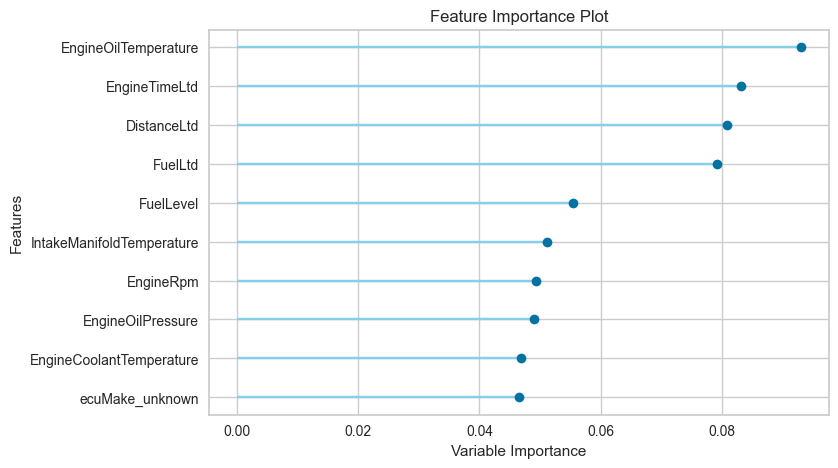

In [11]:
from pycaret.classification import *

# create time series split
split = int(len(ml_features)*0.8)
train_data = ml_features[:split]
test_data = ml_features[split:]

# setup pycaret
clf = setup(data=train_data, target='target', session_id=123, fold_strategy='timeseries')

# train model
#model = create_model('gbc')
#best_model = compare_models()
models_to_exclude = ['lightgbm']

model=compare_models(exclude=models_to_exclude)

# plot feature importance
plot_model(model, plot='feature')

In [12]:
# find the first occurrence of spn = 5246 for each EquipmentID
earliest_timestamps = interpolated_drop.loc[interpolated_drop['spn'] == 5246] \
    .groupby('EquipmentID')['EventTimeStamp'].first()

# create a new column with the time difference in hours between each row and the first occurrence of spn = 5246 for each EquipmentID
interpolated_drop['time_diff'] = (interpolated_drop['EventTimeStamp'] - interpolated_drop['EquipmentID'].map(earliest_timestamps)) \
    .dt.total_seconds() / 3600

# filter the dataframe to keep only the rows where the time difference is less than or equal to 8 hours
filtered_df = interpolated_drop.loc[(interpolated_drop['EquipmentID'].isin(earliest_timestamps.index)) 
    & (interpolated_drop['time_diff'] >= -48)
    & (interpolated_drop['time_diff'] <= 0)]
filtered_df

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuModel,ecuMake,ecuSource,spn,fmi,activeTransitionCount,...,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,Speed,Throttle,TurboBoostPressure,time_diff
5114,5713,1070644,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,4344,5,1,...,72585.630126,5.111745,183.2,True,100.4,22527.0,0.00000,0.0,13.63,0.000000
5115,5714,1070646,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,5246,0,1,...,72585.630126,5.111745,183.2,True,100.4,22527.0,0.00000,0.0,13.63,0.000000
5116,5715,1070647,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,1569,31,1,...,72585.630126,5.111745,183.2,True,100.4,22527.0,0.00000,0.0,13.63,0.000000
5117,5716,1070648,2015-02-25 13:53:08,Low (Severity Medium) Catalyst Tank Temperature,unknown,unknown,0,3031,18,1,...,72585.630126,5.111745,183.2,True,100.4,22527.0,0.00000,0.0,13.63,0.000000
74203,84717,2909659,2015-06-11 16:56:54,Condition Exists Cruise Control Enable Switch,unknown,unknown,49,50353,0,2,...,89147.236496,0.726475,183.2,True,165.2,2.0,0.00000,0.0,0.58,-22.641111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278167,311407,6322249,2015-12-14 18:25:46,Special Instructions Maximum Vehicle Speed Limit,unknown,unknown,49,5246,19,3,...,29591.232405,0.000000,104.0,True,113.0,255.0,46.49119,0.0,28.71,0.000000
905731,1053620,60904453,2018-09-07 05:45:39,Data Drifted High Aftertreatment 1 Outlet NOx,6X1u13D1500000000,CMMNS,0,3226,20,1,...,42183.917866,1.492577,32.0,True,104.0,17407.0,65.39931,30.4,0.87,-5.616944
905733,1053622,60904613,2018-09-07 05:48:43,Condition Exists NOx limits exceeded due to In...,6X1u13D1500000000,CMMNS,0,4094,31,1,...,42184.182038,15.480530,32.0,True,116.6,18431.0,64.72940,0.0,21.46,-5.565833
905745,1053642,60909415,2018-09-07 06:47:05,Condition Exists Engine Protection Torque Derate,6X1u13D1500000000,CMMNS,0,1569,31,1,...,42186.163328,0.515137,32.0,True,145.4,18431.0,0.00000,0.0,0.58,-4.593056


In [13]:
filtered_df.groupby(['spn', 'fmi', 'eventDescription']).size().reset_index(name='count').sort_values('count', ascending=False).head(40)

,spn,fmi,eventDescription,count
11,96,3,High Voltage (Fuel Level),316
17,111,17,Low (Severity Low) Engine Coolant Level,273
39,1569,31,Condition Exists Engine Protection Torque Derate,252
33,829,3,High Voltage (Left Fuel Level Sensor),209
127,5246,0,Condition Exists Engine Protection Torque Derate,113
49,1761,19,Data May Be Invalid Catalyst Tank Level,50
44,1761,9,Abnormal Update Rate Catalyst Tank Level,49
36,929,9,Abnormal Update Rate Tire Location,42
76,3362,31,Condition Exists Catalyst Dosing Unit Input Lines,42
78,3364,9,Abnormal Update Rate Catalyst Tank Reagent Qua...,42


,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(1049, 21)"
4,Transformed data shape,"(1049, 31)"
5,Transformed train set shape,"(734, 31)"
6,Transformed test set shape,"(315, 31)"
7,Ordinal features,1
8,Numeric features,17
9,Categorical features,3


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7515,0.8298,0.7628,0.8048,0.7786,0.4957,0.5043,0.7420
et,Extra Trees Classifier,0.7424,0.8059,0.7608,0.7932,0.7729,0.4757,0.4827,0.7430
gbc,Gradient Boosting Classifier,0.7303,0.8255,0.7678,0.7752,0.7673,0.4460,0.4529,0.7620
ada,Ada Boost Classifier,0.7258,0.8015,0.7533,0.7783,0.7608,0.4426,0.4499,0.6960
dt,Decision Tree Classifier,0.7015,0.6952,0.7379,0.7509,0.7409,0.3878,0.3929,0.6480
ridge,Ridge Classifier,0.6985,0.0000,0.7096,0.7611,0.7294,0.3885,0.3964,0.7170
lda,Linear Discriminant Analysis,0.6924,0.7828,0.7070,0.7537,0.7243,0.3759,0.3837,0.8970
knn,K Neighbors Classifier,0.6848,0.7792,0.6875,0.7560,0.7108,0.3642,0.3735,0.6390
lr,Logistic Regression,0.6697,0.7589,0.7182,0.7167,0.7135,0.3207,0.3248,0.5890
nb,Naive Bayes,0.6697,0.7502,0.7320,0.7097,0.7172,0.3145,0.3190,0.6450


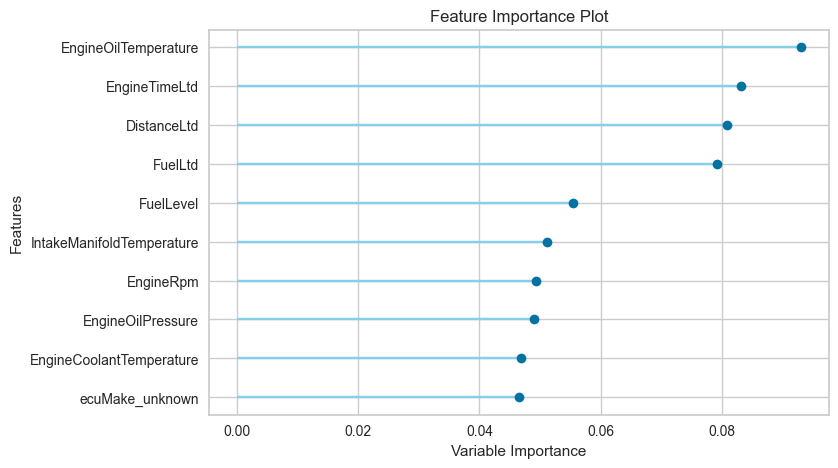

In [14]:
from pycaret.classification import *

# create time series split
split = int(len(ml_features)*0.8)
train_data = ml_features[:split]
test_data = ml_features[split:]

# setup pycaret
clf = setup(data=train_data, target='target', session_id=123, fold_strategy='timeseries')

# train model
#model = create_model('gbc')
#best_model = compare_models()
models_to_exclude = ['lightgbm']

model=compare_models(exclude=models_to_exclude)

# plot feature importance
plot_model(model, plot='feature')

In [15]:
# find the first occurrence of spn = 5246 for each EquipmentID
earliest_timestamps = interpolated_drop.loc[interpolated_drop['spn'] == 5246] \
    .groupby('EquipmentID')['EventTimeStamp'].first()

# create a new column with the time difference in hours between each row and the first occurrence of spn = 5246 for each EquipmentID
interpolated_drop['time_diff'] = (interpolated_drop['EventTimeStamp'] - interpolated_drop['EquipmentID'].map(earliest_timestamps)) \
    .dt.total_seconds() / 3600

# filter the dataframe to keep only the rows where the time difference is less than or equal to 8 hours
filtered_df = interpolated_drop.loc[(interpolated_drop['EquipmentID'].isin(earliest_timestamps.index)) 
    & (interpolated_drop['time_diff'] >= -72)
    & (interpolated_drop['time_diff'] <= 0)]
filtered_df

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuModel,ecuMake,ecuSource,spn,fmi,activeTransitionCount,...,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,Speed,Throttle,TurboBoostPressure,time_diff
5114,5713,1070644,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,4344,5,1,...,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63,0.000000
5115,5714,1070646,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,5246,0,1,...,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63,0.000000
5116,5715,1070647,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,1569,31,1,...,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63,0.000000
5117,5716,1070648,2015-02-25 13:53:08,Low (Severity Medium) Catalyst Tank Temperature,unknown,unknown,0,3031,18,1,...,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63,0.000000
71850,82140,2865286,2015-06-09 15:40:51,Condition Exists Cruise Control Enable Switch,unknown,unknown,49,50353,0,2,...,88970.769565,0.000000,183.2,True,111.2,2.0,61.962360,0.0,9.86,-71.908611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905111,1052848,60579160,2018-09-04 13:51:55,Incorrect Data J1939 Network #1 Primary Vehicl...,EC60-adv,BNDWS,11,639,2,127,...,42134.781864,2.311513,32.0,True,140.0,1279.0,4.417561,0.0,2.32,-69.512500
905731,1053620,60904453,2018-09-07 05:45:39,Data Drifted High Aftertreatment 1 Outlet NOx,6X1u13D1500000000,CMMNS,0,3226,20,1,...,42183.917866,1.492577,32.0,True,104.0,17407.0,65.399310,30.4,0.87,-5.616944
905733,1053622,60904613,2018-09-07 05:48:43,Condition Exists NOx limits exceeded due to In...,6X1u13D1500000000,CMMNS,0,4094,31,1,...,42184.182038,15.480530,32.0,True,116.6,18431.0,64.729400,0.0,21.46,-5.565833
905745,1053642,60909415,2018-09-07 06:47:05,Condition Exists Engine Protection Torque Derate,6X1u13D1500000000,CMMNS,0,1569,31,1,...,42186.163328,0.515137,32.0,True,145.4,18431.0,0.000000,0.0,0.58,-4.593056


In [16]:
filtered_df.groupby(['spn', 'fmi', 'eventDescription']).size().reset_index(name='count').sort_values('count', ascending=False).head(40)

,spn,fmi,eventDescription,count
22,111,17,Low (Severity Low) Engine Coolant Level,372
13,96,3,High Voltage (Fuel Level),320
52,1569,31,Condition Exists Engine Protection Torque Derate,302
45,829,3,High Voltage (Left Fuel Level Sensor),213
147,5246,0,Condition Exists Engine Protection Torque Derate,113
62,1761,19,Data May Be Invalid Catalyst Tank Level,59
57,1761,9,Abnormal Update Rate Catalyst Tank Level,58
94,3364,9,Abnormal Update Rate Catalyst Tank Reagent Qua...,51
48,929,9,Abnormal Update Rate Tire Location,51
92,3362,31,Condition Exists Catalyst Dosing Unit Input Lines,48


,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(1049, 21)"
4,Transformed data shape,"(1049, 31)"
5,Transformed train set shape,"(734, 31)"
6,Transformed test set shape,"(315, 31)"
7,Ordinal features,1
8,Numeric features,17
9,Categorical features,3


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7515,0.8298,0.7628,0.8048,0.7786,0.4957,0.5043,0.7150
et,Extra Trees Classifier,0.7424,0.8059,0.7608,0.7932,0.7729,0.4757,0.4827,0.7040
gbc,Gradient Boosting Classifier,0.7303,0.8255,0.7678,0.7752,0.7673,0.4460,0.4529,0.6890
ada,Ada Boost Classifier,0.7258,0.8015,0.7533,0.7783,0.7608,0.4426,0.4499,0.6870
dt,Decision Tree Classifier,0.7015,0.6952,0.7379,0.7509,0.7409,0.3878,0.3929,0.6600
ridge,Ridge Classifier,0.6985,0.0000,0.7096,0.7611,0.7294,0.3885,0.3964,0.6540
lda,Linear Discriminant Analysis,0.6924,0.7828,0.7070,0.7537,0.7243,0.3759,0.3837,0.6250
knn,K Neighbors Classifier,0.6848,0.7792,0.6875,0.7560,0.7108,0.3642,0.3735,0.6600
lr,Logistic Regression,0.6697,0.7589,0.7182,0.7167,0.7135,0.3207,0.3248,0.6160
nb,Naive Bayes,0.6697,0.7502,0.7320,0.7097,0.7172,0.3145,0.3190,0.6550


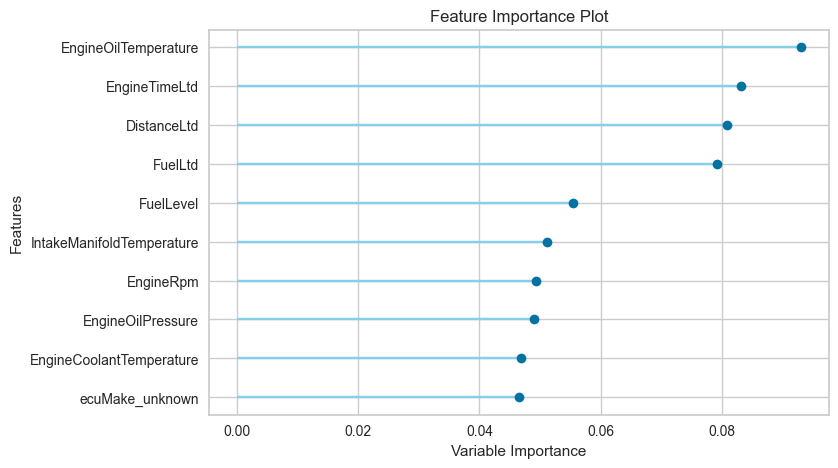

In [17]:
from pycaret.classification import *

# create time series split
split = int(len(ml_features)*0.8)
train_data = ml_features[:split]
test_data = ml_features[split:]

# setup pycaret
clf = setup(data=train_data, target='target', session_id=123, fold_strategy='timeseries')

# train model
#model = create_model('gbc')
#best_model = compare_models()
models_to_exclude = ['lightgbm']

model=compare_models(exclude=models_to_exclude)

# plot feature importance
plot_model(model, plot='feature')

In [18]:
# find the first occurrence of spn = 5246 for each EquipmentID
earliest_timestamps = interpolated_drop.loc[interpolated_drop['spn'] == 5246] \
    .groupby('EquipmentID')['EventTimeStamp'].first()

# create a new column with the time difference in hours between each row and the first occurrence of spn = 5246 for each EquipmentID
interpolated_drop['time_diff'] = (interpolated_drop['EventTimeStamp'] - interpolated_drop['EquipmentID'].map(earliest_timestamps)) \
    .dt.total_seconds() / 3600

# filter the dataframe to keep only the rows where the time difference is less than or equal to 8 hours
filtered_df = interpolated_drop.loc[(interpolated_drop['EquipmentID'].isin(earliest_timestamps.index)) 
    & (interpolated_drop['time_diff'] >= -120)
    & (interpolated_drop['time_diff'] <= 0)]
filtered_df

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuModel,ecuMake,ecuSource,spn,fmi,activeTransitionCount,...,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,Speed,Throttle,TurboBoostPressure,time_diff
5114,5713,1070644,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,4344,5,1,...,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63,0.000000
5115,5714,1070646,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,5246,0,1,...,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63,0.000000
5116,5715,1070647,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,1569,31,1,...,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63,0.000000
5117,5716,1070648,2015-02-25 13:53:08,Low (Severity Medium) Catalyst Tank Temperature,unknown,unknown,0,3031,18,1,...,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63,0.000000
70982,81203,2848431,2015-06-08 20:12:38,Condition Exists Cruise Control Enable Switch,unknown,unknown,49,50353,0,2,...,88907.632445,5.785386,183.2,True,84.2,2.0,57.641890,0.0,6.96,-91.378889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905111,1052848,60579160,2018-09-04 13:51:55,Incorrect Data J1939 Network #1 Primary Vehicl...,EC60-adv,BNDWS,11,639,2,127,...,42134.781864,2.311513,32.0,True,140.0,1279.0,4.417561,0.0,2.32,-69.512500
905731,1053620,60904453,2018-09-07 05:45:39,Data Drifted High Aftertreatment 1 Outlet NOx,6X1u13D1500000000,CMMNS,0,3226,20,1,...,42183.917866,1.492577,32.0,True,104.0,17407.0,65.399310,30.4,0.87,-5.616944
905733,1053622,60904613,2018-09-07 05:48:43,Condition Exists NOx limits exceeded due to In...,6X1u13D1500000000,CMMNS,0,4094,31,1,...,42184.182038,15.480530,32.0,True,116.6,18431.0,64.729400,0.0,21.46,-5.565833
905745,1053642,60909415,2018-09-07 06:47:05,Condition Exists Engine Protection Torque Derate,6X1u13D1500000000,CMMNS,0,1569,31,1,...,42186.163328,0.515137,32.0,True,145.4,18431.0,0.000000,0.0,0.58,-4.593056


In [19]:
filtered_df.groupby(['spn', 'fmi', 'eventDescription']).size().reset_index(name='count').sort_values('count', ascending=False).head(40)

,spn,fmi,eventDescription,count
23,111,17,Low (Severity Low) Engine Coolant Level,655
13,96,3,High Voltage (Fuel Level),509
53,829,3,High Voltage (Left Fuel Level Sensor),346
61,1569,31,Condition Exists Engine Protection Torque Derate,328
163,5246,0,Condition Exists Engine Protection Torque Derate,113
66,1761,9,Abnormal Update Rate Catalyst Tank Level,65
71,1761,19,Data May Be Invalid Catalyst Tank Level,65
106,3364,9,Abnormal Update Rate Catalyst Tank Reagent Qua...,55
104,3362,31,Condition Exists Catalyst Dosing Unit Input Lines,54
56,929,9,Abnormal Update Rate Tire Location,52


,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(1049, 21)"
4,Transformed data shape,"(1049, 31)"
5,Transformed train set shape,"(734, 31)"
6,Transformed test set shape,"(315, 31)"
7,Ordinal features,1
8,Numeric features,17
9,Categorical features,3


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7515,0.8298,0.7628,0.8048,0.7786,0.4957,0.5043,0.7540
et,Extra Trees Classifier,0.7424,0.8059,0.7608,0.7932,0.7729,0.4757,0.4827,0.7140
gbc,Gradient Boosting Classifier,0.7303,0.8255,0.7678,0.7752,0.7673,0.4460,0.4529,0.6580
ada,Ada Boost Classifier,0.7258,0.8015,0.7533,0.7783,0.7608,0.4426,0.4499,0.6780
dt,Decision Tree Classifier,0.7015,0.6952,0.7379,0.7509,0.7409,0.3878,0.3929,0.6600
ridge,Ridge Classifier,0.6985,0.0000,0.7096,0.7611,0.7294,0.3885,0.3964,0.6270
lda,Linear Discriminant Analysis,0.6924,0.7828,0.7070,0.7537,0.7243,0.3759,0.3837,0.6510
knn,K Neighbors Classifier,0.6848,0.7792,0.6875,0.7560,0.7108,0.3642,0.3735,0.6480
lr,Logistic Regression,0.6697,0.7589,0.7182,0.7167,0.7135,0.3207,0.3248,0.5970
nb,Naive Bayes,0.6697,0.7502,0.7320,0.7097,0.7172,0.3145,0.3190,0.6450


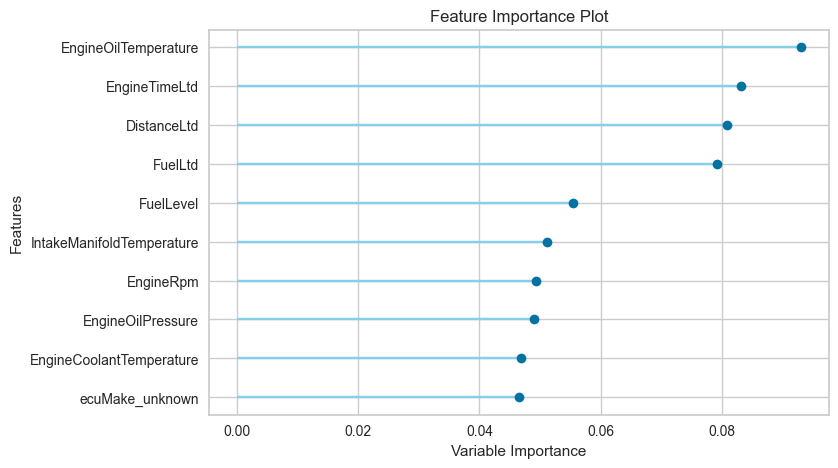

In [20]:
from pycaret.classification import *

# create time series split
split = int(len(ml_features)*0.8)
train_data = ml_features[:split]
test_data = ml_features[split:]

# setup pycaret
clf = setup(data=train_data, target='target', session_id=123, fold_strategy='timeseries')

# train model
#model = create_model('gbc')
#best_model = compare_models()
models_to_exclude = ['lightgbm']

model=compare_models(exclude=models_to_exclude)

# plot feature importance
plot_model(model, plot='feature')

In [21]:
# find the first occurrence of spn = 5246 for each EquipmentID
earliest_timestamps = interpolated_drop.loc[interpolated_drop['spn'] == 5246] \
    .groupby('EquipmentID')['EventTimeStamp'].first()

# create a new column with the time difference in hours between each row and the first occurrence of spn = 5246 for each EquipmentID
interpolated_drop['time_diff'] = (interpolated_drop['EventTimeStamp'] - interpolated_drop['EquipmentID'].map(earliest_timestamps)) \
    .dt.total_seconds() / 3600

# filter the dataframe to keep only the rows where the time difference is less than or equal to 8 hours
filtered_df = interpolated_drop.loc[(interpolated_drop['EquipmentID'].isin(earliest_timestamps.index)) 
    & (interpolated_drop['time_diff'] >= -168)
    & (interpolated_drop['time_diff'] <= 0)]
filtered_df

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuModel,ecuMake,ecuSource,spn,fmi,activeTransitionCount,...,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,Speed,Throttle,TurboBoostPressure,time_diff
5114,5713,1070644,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,4344,5,1,...,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63,0.000000
5115,5714,1070646,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,5246,0,1,...,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63,0.000000
5116,5715,1070647,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,1569,31,1,...,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63,0.000000
5117,5716,1070648,2015-02-25 13:53:08,Low (Severity Medium) Catalyst Tank Temperature,unknown,unknown,0,3031,18,1,...,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63,0.000000
69186,79284,2823875,2015-06-07 07:50:25,Condition Exists Cruise Control Enable Switch,unknown,unknown,0,4364,18,1,...,88558.132820,0.000000,183.2,True,96.8,17407.0,64.108030,0.0,2.32,-127.749167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905111,1052848,60579160,2018-09-04 13:51:55,Incorrect Data J1939 Network #1 Primary Vehicl...,EC60-adv,BNDWS,11,639,2,127,...,42134.781864,2.311513,32.0,True,140.0,1279.0,4.417561,0.0,2.32,-69.512500
905731,1053620,60904453,2018-09-07 05:45:39,Data Drifted High Aftertreatment 1 Outlet NOx,6X1u13D1500000000,CMMNS,0,3226,20,1,...,42183.917866,1.492577,32.0,True,104.0,17407.0,65.399310,30.4,0.87,-5.616944
905733,1053622,60904613,2018-09-07 05:48:43,Condition Exists NOx limits exceeded due to In...,6X1u13D1500000000,CMMNS,0,4094,31,1,...,42184.182038,15.480530,32.0,True,116.6,18431.0,64.729400,0.0,21.46,-5.565833
905745,1053642,60909415,2018-09-07 06:47:05,Condition Exists Engine Protection Torque Derate,6X1u13D1500000000,CMMNS,0,1569,31,1,...,42186.163328,0.515137,32.0,True,145.4,18431.0,0.000000,0.0,0.58,-4.593056


In [22]:
filtered_df.groupby(['spn', 'fmi', 'eventDescription']).size().reset_index(name='count').sort_values('count', ascending=False).head(40)

,spn,fmi,eventDescription,count
14,96,3,High Voltage (Fuel Level),1082
26,111,17,Low (Severity Low) Engine Coolant Level,899
66,829,3,High Voltage (Left Fuel Level Sensor),773
77,1569,31,Condition Exists Engine Protection Torque Derate,340
189,5246,0,Condition Exists Engine Protection Torque Derate,113
82,1761,9,Abnormal Update Rate Catalyst Tank Level,73
87,1761,19,Data May Be Invalid Catalyst Tank Level,72
125,3364,9,Abnormal Update Rate Catalyst Tank Reagent Qua...,62
72,1068,2,Incorrect Data Brake Signal Sensor 2,58
70,929,9,Abnormal Update Rate Tire Location,56


,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(1049, 21)"
4,Transformed data shape,"(1049, 31)"
5,Transformed train set shape,"(734, 31)"
6,Transformed test set shape,"(315, 31)"
7,Ordinal features,1
8,Numeric features,17
9,Categorical features,3


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7515,0.8298,0.7628,0.8048,0.7786,0.4957,0.5043,0.7340
et,Extra Trees Classifier,0.7424,0.8059,0.7608,0.7932,0.7729,0.4757,0.4827,0.8040
gbc,Gradient Boosting Classifier,0.7303,0.8255,0.7678,0.7752,0.7673,0.4460,0.4529,0.7280
ada,Ada Boost Classifier,0.7258,0.8015,0.7533,0.7783,0.7608,0.4426,0.4499,0.7290
dt,Decision Tree Classifier,0.7015,0.6952,0.7379,0.7509,0.7409,0.3878,0.3929,0.6570
ridge,Ridge Classifier,0.6985,0.0000,0.7096,0.7611,0.7294,0.3885,0.3964,0.6270
lda,Linear Discriminant Analysis,0.6924,0.7828,0.7070,0.7537,0.7243,0.3759,0.3837,0.6920
knn,K Neighbors Classifier,0.6848,0.7792,0.6875,0.7560,0.7108,0.3642,0.3735,0.6700
lr,Logistic Regression,0.6697,0.7589,0.7182,0.7167,0.7135,0.3207,0.3248,0.6100
nb,Naive Bayes,0.6697,0.7502,0.7320,0.7097,0.7172,0.3145,0.3190,0.6730


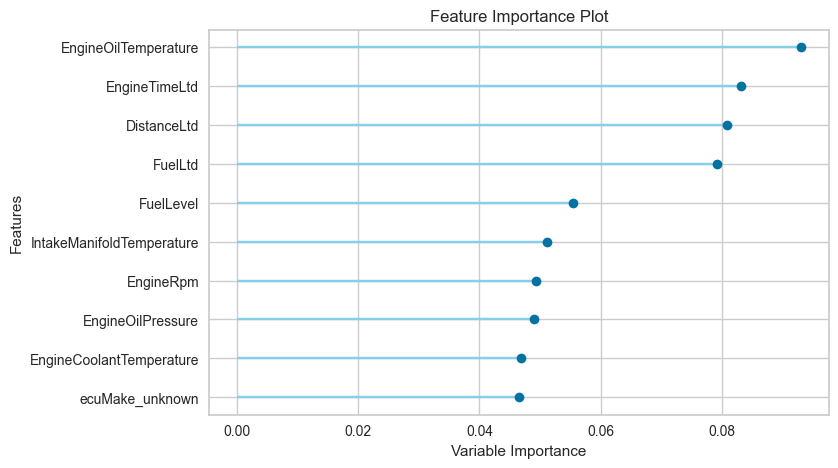

In [23]:
from pycaret.classification import *

# create time series split
split = int(len(ml_features)*0.8)
train_data = ml_features[:split]
test_data = ml_features[split:]

# setup pycaret
clf = setup(data=train_data, target='target', session_id=123, fold_strategy='timeseries')

# train model
#model = create_model('gbc')
#best_model = compare_models()
models_to_exclude = ['lightgbm']

model=compare_models(exclude=models_to_exclude)

# plot feature importance
plot_model(model, plot='feature')